# CS 512 Project by:-
# Aman Kumar (A20538809)
# Qiuping Zhang (A20520304)
# Title:- High-Efficiency Neural Networks for Mobile Vision Tasks

# Importing the required Modules

In [1]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
import h5py
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score

# Inverted Residual Block with Linear Bottleneck Implementation

In [2]:
# Inverted residual block with linear bottleneck
def inverted_residual_block(x, filters, stride, expansion):
    shortcut = x
    expanded_filters = tf.keras.backend.int_shape(x)[-1] * expansion

    # The Expansion layer
    if expansion != 1:
        x = Conv2D(expanded_filters, kernel_size=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU(6.)(x)

    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    # Below is the Projection layer which reduces channels back to `filters`
    x = Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # This below is the Residual connection to check if dimensions match
    if stride == 1 and tf.keras.backend.int_shape(shortcut)[-1] == filters:
        x = Add()([x, shortcut])

    return x

# MobileNetV2 Architecture Definition

In [3]:
# Here we have defined the Mobile Net V2 architecture
def MobileNetV2(input_shape=(224, 224, 3), num_classes=20):
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    # This is the block configurations for Mobile net V2
    inverted_residual_setting = [
        (1, 16, 1, 1),
        (6, 24, 2, 2),
        (6, 32, 2, 3),
        (6, 64, 2, 4),
        (6, 96, 1, 3),
        (6, 160, 2, 3),
        (6, 320, 1, 1),
    ]

    for t, c, s, n in inverted_residual_setting:
        for i in range(n):
            x = inverted_residual_block(x, c, s if i == 0 else 1, t)

    # Final layers of the Mobile net v2 architecture
    x = Conv2D(1280, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.load_weights('/Users/amansingh/Desktop/cv_project_dry_run/custom_mobilenetv2_imagenet_weights_for_20_classes.weights.h5')

    return model

# MobileNetV2 Model Creation and Summary

In [4]:
# Model instantiation for 20 classes as per PASCAL VOC 2007 dataset
model = MobileNetV2(input_shape=(224, 224, 3), num_classes=20)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │        512 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      1,536 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        864 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │      2,304 │ re_lu_3[0][0]     │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         96 │ conv2d_3[0][0]  

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 2,249,492 (8.58 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Dataset Preprocessing with Image and Label Handling

In [5]:
# number of epochs, batch size, image size and Autotuning
BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

#data preprocessing block
def preprocess_data(example, label_names):

    #image preprocessing sub-block below:-
    image = example['image']
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = (image / 127.5) - 1

    #labels pre-processing below
    labels = tf.zeros(len(label_names), dtype=tf.float32)
    objects = example['objects']
    label_ids = objects['label']

    #here we are creating one-hot encoding tensor
    for label_id in label_ids:
        labels = tf.tensor_scatter_nd_update(
            labels,
            [[label_id]],
            [1.0]
        )

    return image, labels

# Data Augmentation for Improved Generalization and Robustness

In [6]:
# performs data augmentation on the input images to improve model generalization and robustness
def apply_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, -1, 1)
    return image, label

# Dataset Preparation with Preprocessing, Augmentation, and Shuffling

In [7]:
#prepares proprocessing for images and labels in the below code and shuffles data as well
def prepare_dataset(dataset, label_names, is_training=True):
    dataset = dataset.map(lambda x: preprocess_data(x, label_names), num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(10000)
        dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Model Training 

In [8]:
def main():
    output_dir = 'model_output'
    os.makedirs(output_dir, exist_ok=True)

    # Load dataset and retrieve label names dynamically
    dataset, info = tfds.load(
        'voc/2007',
        split=['train', 'validation'],  # Use designated training and validation splits
        with_info=True
    )
    label_names = info.features['objects']['label'].names
    train_dataset, validation_dataset = dataset[0], dataset[1]

    # Prepare the datasets
    train_dataset = prepare_dataset(train_dataset, label_names, is_training=True)
    validation_dataset = prepare_dataset(validation_dataset, label_names, is_training=False)

    print("Creating model...")
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=len(label_names))

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # training for 30 epochs with early stopping with medium patience of 7
    callbacks = [
        ModelCheckpoint(
            os.path.join(output_dir, 'mobilenetv2_pascal_best.keras'),
            monitor='val_accuracy',  # Monitoring on the validation set
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduces the learning rate when validation loss plateaus with a minimum learning rate of 1e-6.
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]

    #train the model for 30 epochs with callbacks that include early stopping as well
    print("\nStarting training...")
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    model.save(os.path.join(output_dir, 'mobilenetv2_pascal_final.keras'))

    return history

#run the main function
if __name__ == "__main__":
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)

    history = main()

Creating model...

Starting training...
Epoch 1/30


2024-11-15 13:25:12.513924: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9351 - auc: 0.8712 - loss: 0.1960 - precision: 0.8289 - recall: 0.2238
Epoch 1: val_accuracy improved from -inf to 0.93239, saving model to model_output/mobilenetv2_pascal_best.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9351 - auc: 0.8716 - loss: 0.1958 - precision: 0.8293 - recall: 0.2242 - val_accuracy: 0.9324 - val_auc: 0.7966 - val_loss: 0.3420 - val_precision: 0.6091 - val_recall: 0.3596 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9463 - auc: 0.9529 - loss: 0.1388 - precision: 0.9163 - recall: 0.3619
Epoch 2: val_accuracy did not improve from 0.93239
79/79 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9463 - auc: 0.9529 - loss: 0.1389 - precision: 0.9163 - recall: 0.3619 - val_accuracy: 0.9313 - val_auc: 0.8560 - val_loss: 0.2472 - val_precision: 0.6189 - val_recall: 0.2972 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9466 - au

# Model Predictions with Actual Labels function:-

In [9]:
def display_more_predictions(model, dataset, label_names, num_images=15, threshold=0.3):
    # Initialize counter for displayed images
    displayed_count = 0

    # Loop through dataset batches
    for images, labels in dataset:
        predictions = model.predict(images)

        for i in range(len(images)):
            if displayed_count >= num_images:
                return

            plt.figure(figsize=(5, 5))
            plt.imshow((images[i] + 1) / 2)  
            plt.axis('off')

            # show actual labels and the predictions:-
            actual_labels = [label_names[j] for j in range(len(label_names)) if labels[i][j] == 1]
            predicted_labels = [label_names[j] for j in range(len(label_names)) if predictions[i][j] > threshold]

            # when no labels is able to meet the model predictions:-
            if not predicted_labels:
                predicted_labels = ["No confident prediction"]

            plt.title(f"Actual: {', '.join(actual_labels)}\nPredicted: {', '.join(predicted_labels)}")
            plt.show()

            displayed_count += 1

# Test Dataset Preparation and Display the Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


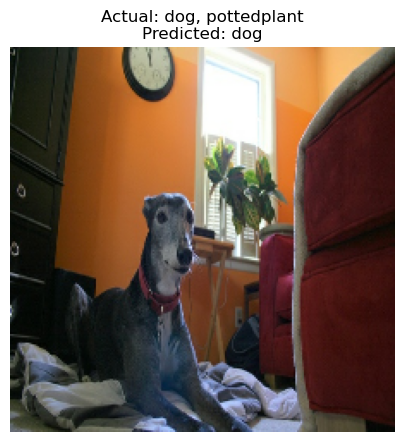

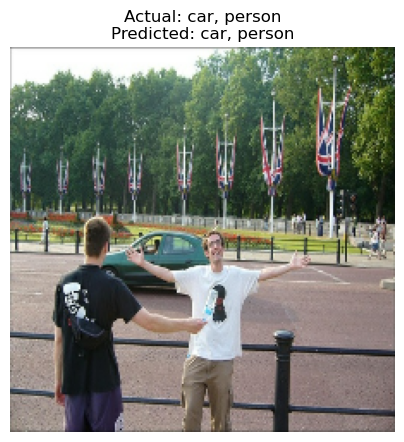

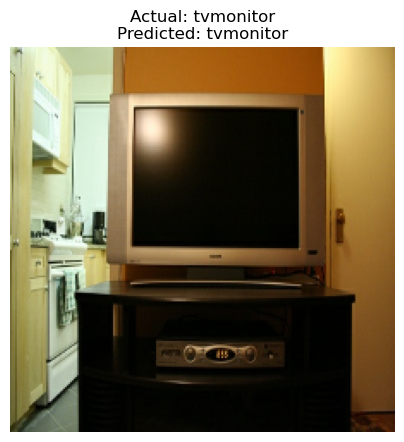

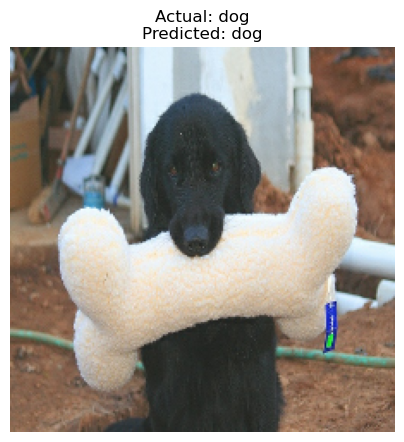

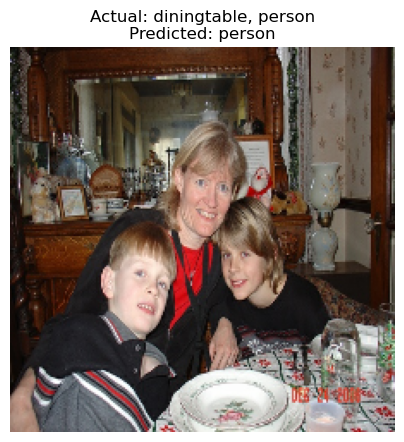

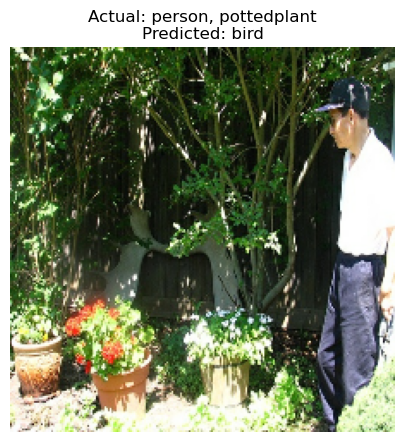

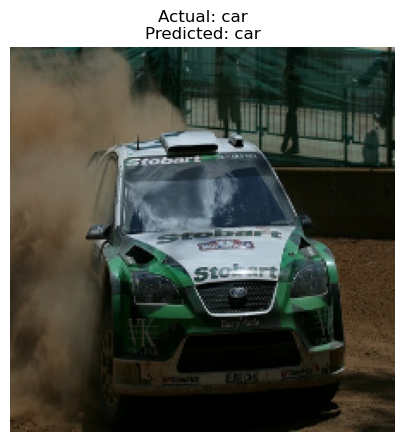

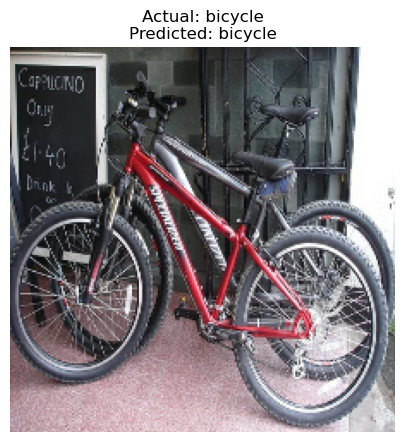

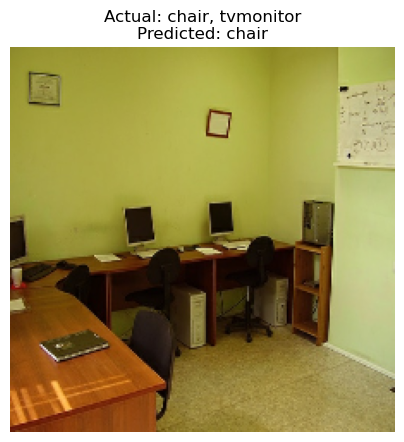

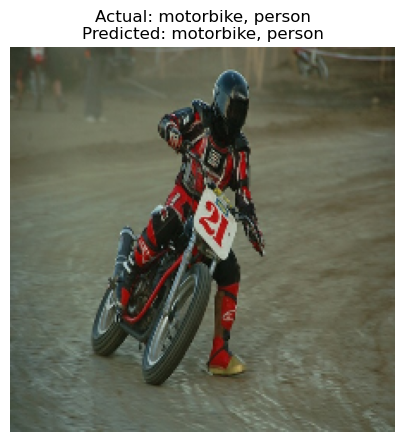

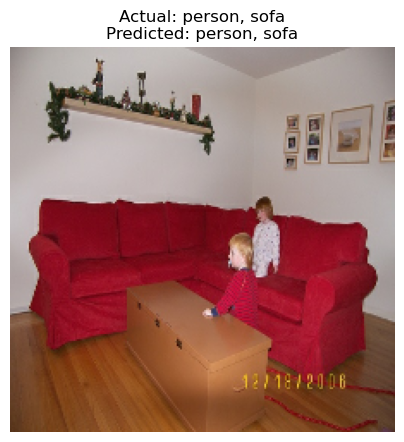

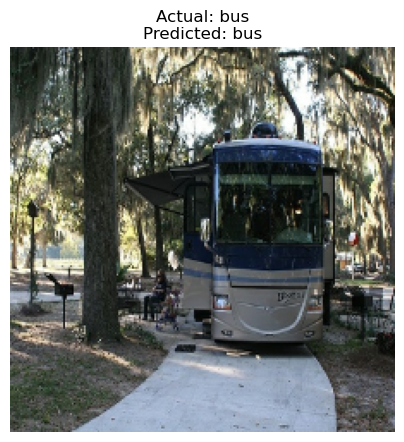

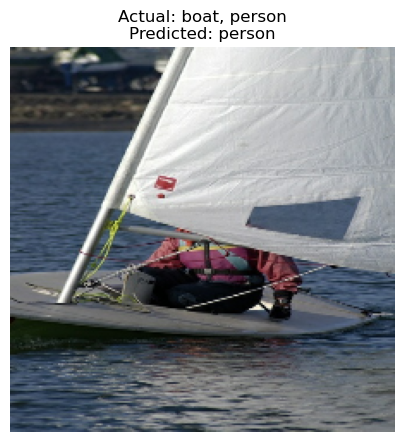

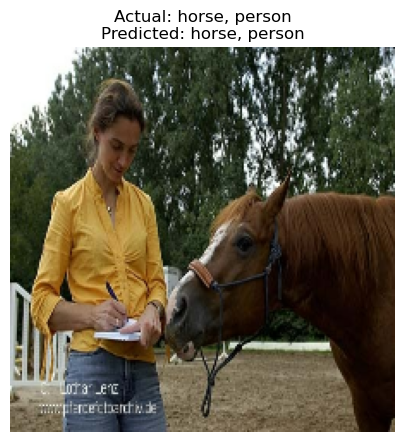

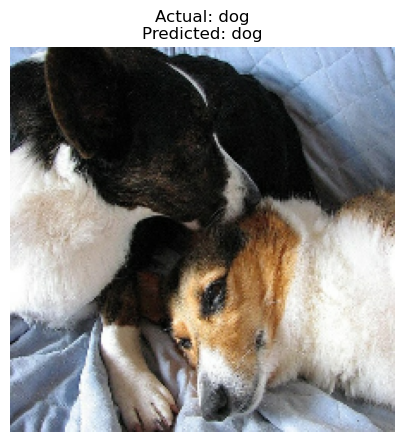

In [10]:
# Load and prepare the test dataset
test_dataset, info = tfds.load(
    'voc/2007',
    split='test',
    with_info=True
)

# here we are getting the label names
label_names = info.features['objects']['label'].names

# preparartion of the test dataset
test_dataset = prepare_dataset(test_dataset, label_names=label_names, is_training=False)

# Loading the trained model to test o test dataset
model_path = '/Users/amansingh/Desktop/cv_project_dry_run/model_output/mobilenetv2_pascal_best.keras' 
model = tf.keras.models.load_model(model_path)

# Display predictions on more test images
display_more_predictions(model, test_dataset, label_names=label_names, num_images=15, threshold=0.3)

# Evaluation of Model Metrics

In [11]:
from tqdm import tqdm

# test dataset labels
label_names = info.features['objects']['label'].names

# Evaluation metrics 
def evaluate_metrics_with_progress_bar(model, dataset, label_names, threshold=0.5):
    y_true = []
    y_pred = []
    y_scores = []
    accuracies = []  

    # Create a progress bar
    for images, labels in tqdm(dataset, desc="Evaluating metrics", unit="batch"):
        # Get model predictions
        predictions = model(images, training=False)

        # threshold for predictions
        predictions = tf.cast(predictions > threshold, tf.int32)

        # accuracy for the batch
        batch_accuracy = np.mean(np.equal(np.argmax(predictions, axis=-1), np.argmax(labels, axis=-1)))
        accuracies.append(batch_accuracy)

        y_true.append(labels.numpy())
        y_pred.append(predictions.numpy())
        y_scores.append(predictions.numpy())  

    # Convert to numpy arrays
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_scores = np.concatenate(y_scores, axis=0)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=1)

    # Compute AUC value for each class
    auc_scores = []
    for i in range(len(label_names)):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i]) if y_true.shape[1] > i else None
        auc_scores.append(auc)

    return report, auc_scores, accuracies

# Generate Model Evaluation Report and AUC Scores

In [12]:
from tqdm import tqdm

# Call the function 
report, auc_scores, accuracies = evaluate_metrics_with_progress_bar(model, test_dataset, label_names)

Evaluating metrics: 100%|██████████████████| 155/155 [01:14<00:00,  2.08batch/s]


# Display plots for Precision, Recall and F-1 Score per class:-

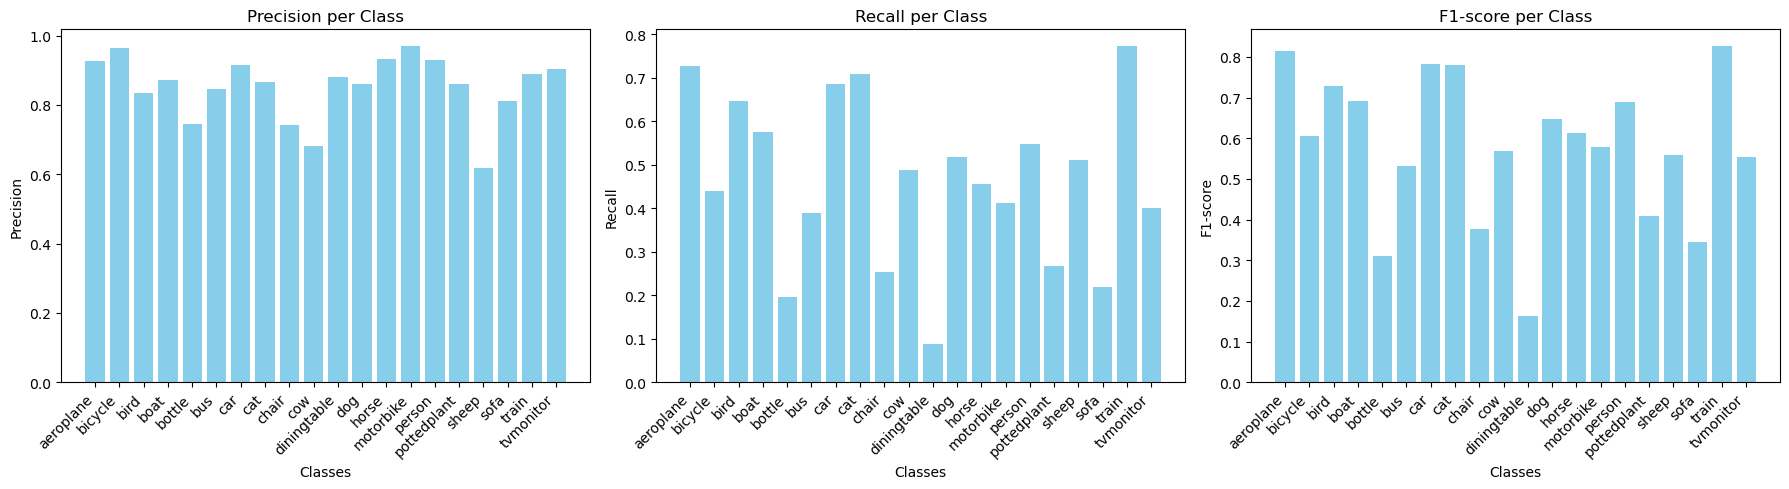

In [13]:
# function for classification report 
def plot_classification_report(report, label_names):
    metrics = ['precision', 'recall', 'f1-score']
    data = {metric: [] for metric in metrics}

    for class_name in label_names:
        for metric in metrics:
            data[metric].append(report[class_name][metric])

    # Plots for precision, recall and F-1 Score:-
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))
    for i, metric in enumerate(metrics):
        axes[i].bar(label_names, data[metric], color='skyblue')
        axes[i].set_title(f'{metric.capitalize()} per Class')
        axes[i].set_xticks(range(len(label_names)))  
        axes[i].set_xticklabels(label_names, rotation=45, ha="right")
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()


plot_classification_report(report, label_names)

# Visualization of AUC Scores for Each Class

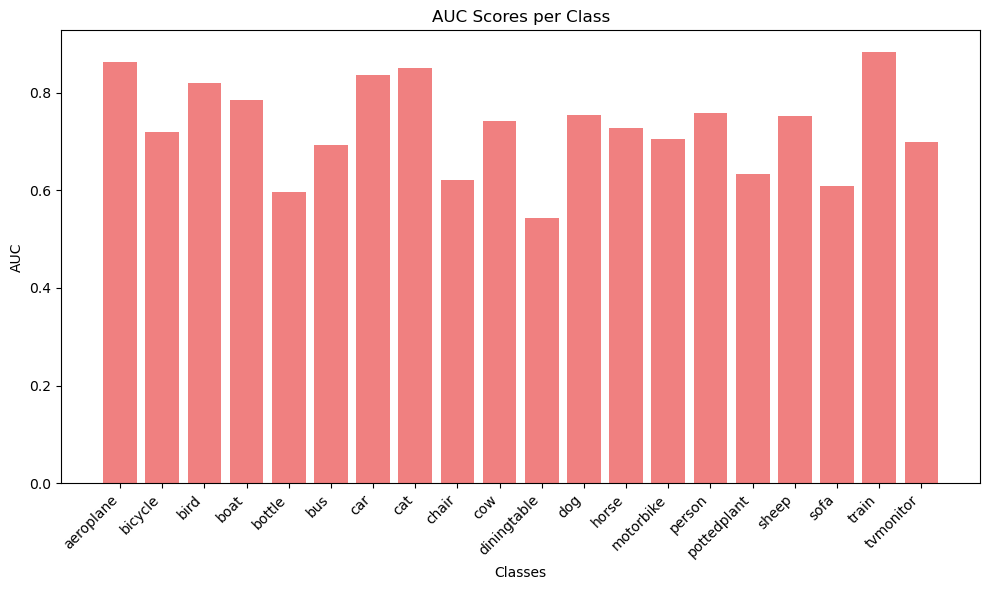

In [14]:
def plot_auc_scores(auc_scores, label_names):
    plt.figure(figsize=(10, 6))
    plt.bar(label_names, auc_scores, color='lightcoral')
    plt.title('AUC Scores per Class')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel('Classes')
    plt.ylabel('AUC')
    plt.tight_layout()
    plt.show()

plot_auc_scores(auc_scores, label_names)

# Plotting Model Accuracy per Batch

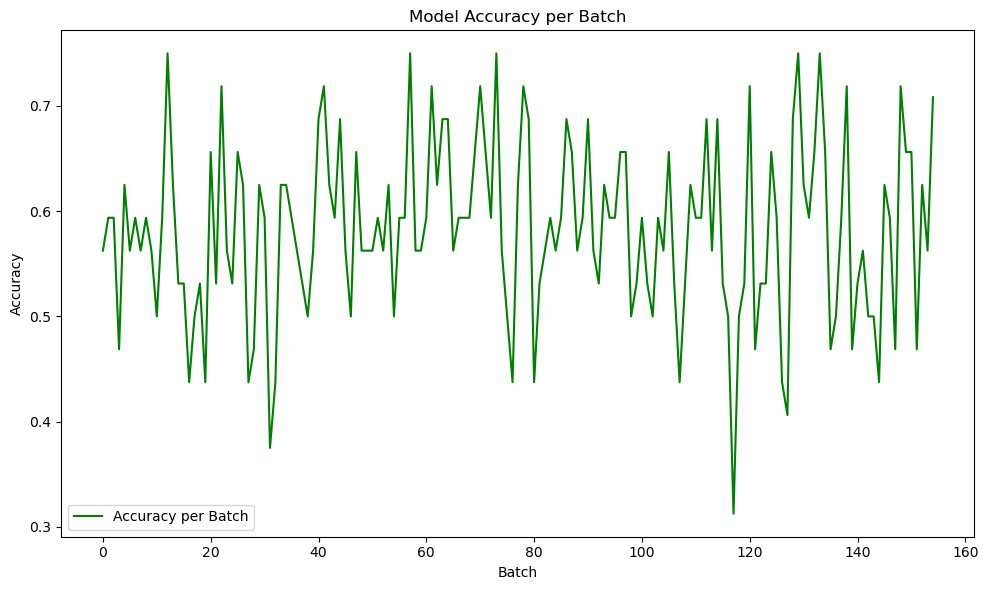

In [15]:
def plot_accuracy(accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(accuracies, label='Accuracy per Batch', color='green')
    plt.title('Model Accuracy per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_accuracy(accuracies)

# Precision, Recall, F-1 and AUC scores for all classes:-

In [16]:
# Print the final outputs
print("\nFinal Classification Report:")
for class_name, metrics in report.items():
    print(f"{class_name}: {metrics}")

print("\nAUC Scores:")
for idx, auc in enumerate(auc_scores):
    if auc is not None:
        print(f"AUC for {label_names[idx]}: {auc:.4f}")
    else:
        print(f"AUC for {label_names[idx]}: Not computable")


Final Classification Report:
aeroplane: {'precision': 0.9254658385093167, 'recall': 0.7268292682926829, 'f1-score': 0.8142076502732241, 'support': 205.0}
bicycle: {'precision': 0.9649122807017544, 'recall': 0.44, 'f1-score': 0.6043956043956044, 'support': 250.0}
bird: {'precision': 0.8348214285714286, 'recall': 0.6470588235294118, 'f1-score': 0.7290448343079922, 'support': 289.0}
boat: {'precision': 0.8706896551724138, 'recall': 0.5738636363636364, 'f1-score': 0.6917808219178082, 'support': 176.0}
bottle: {'precision': 0.746031746031746, 'recall': 0.19583333333333333, 'f1-score': 0.3102310231023102, 'support': 240.0}
bus: {'precision': 0.8452380952380952, 'recall': 0.3879781420765027, 'f1-score': 0.5318352059925093, 'support': 183.0}
car: {'precision': 0.9155172413793103, 'recall': 0.6851612903225807, 'f1-score': 0.7837638376383764, 'support': 775.0}
cat: {'precision': 0.8671586715867159, 'recall': 0.7078313253012049, 'f1-score': 0.7794361525704809, 'support': 332.0}
chair: {'precisio

# Mean Intersection over Union (mIOU)

In [17]:
from tqdm import tqdm

# Function to calculate mIOU for the model with a progress bar
def calculate_mean_iou(model, dataset, num_classes):
    # Initialize MeanIoU metric
    miou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    # Create a progress bar
    dataset = tqdm(dataset, desc="Processing batches", unit="batch")

    # Iterate over test dataset
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        predicted_labels = tf.argmax(predictions, axis=-1) #predicted lables
        true_labels = tf.argmax(labels, axis=-1) #true labels

        # Update the mIOU metric with the true and predicted labels
        miou_metric.update_state(true_labels, predicted_labels)

    # final #mIOU score
    mean_iou = miou_metric.result().numpy()
    print(f"Mean Intersection over Union (mIOU): {mean_iou:.4f}")
    return mean_iou

# Load the test dataset 
num_classes = 20  
mean_iou = calculate_mean_iou(model, test_dataset, num_classes)


Processing batches: 100%|██████████████████| 155/155 [00:41<00:00,  3.74batch/s]

Mean Intersection over Union (mIOU): 0.4415


# Calculating Mean Intersection over Union (mIOU) and Per-Class mIOU values

In [18]:
from tqdm import tqdm

# mIOU per class
def calculate_mean_iou_per_class(model, dataset, num_classes):
    # Initialize MeanIoU metric
    confusion_matrix = tf.zeros((num_classes, num_classes), dtype=tf.int32)
    dataset = tqdm(dataset, desc="Processing batches", unit="batch")

    # loop over test dataset
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        predicted_labels = tf.argmax(predictions, axis=-1)
        true_labels = tf.argmax(labels, axis=-1)

        # Update the confusion matrix
        for true, pred in zip(tf.reshape(true_labels, [-1]), tf.reshape(predicted_labels, [-1])):
            if true < num_classes and pred < num_classes:  # Ensure labels are valid
                confusion_matrix = tf.tensor_scatter_nd_add(
                    confusion_matrix, [[true, pred]], [1]
                )

    # mIOU per class
    intersection = tf.linalg.diag_part(confusion_matrix)
    union = tf.reduce_sum(confusion_matrix, axis=0) + tf.reduce_sum(confusion_matrix, axis=1) - intersection
    iou_per_class = intersection / tf.maximum(union, 1)

    # Mean mIOU across classes
    mean_iou = tf.reduce_mean(iou_per_class).numpy()

    print(f"Mean Intersection over Union (mIOU): {mean_iou:.4f}")
    print("Per-Class mIOU:")
    for i, iou in enumerate(iou_per_class.numpy()):
        print(f"{class_names[i]}: mIOU = {iou:.4f}")

    return mean_iou, iou_per_class.numpy()


# 20 classes 
num_classes = 20  
class_names = [
    "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow",
    "Dining Table", "Dog", "Horse", "Motorbike", "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV Monitor"
]

mean_iou, iou_per_class = calculate_mean_iou_per_class(model, test_dataset, num_classes)

Processing batches: 100%|██████████████████| 155/155 [00:42<00:00,  3.69batch/s]

Mean Intersection over Union (mIOU): 0.4415
Per-Class mIOU:
Aeroplane: mIOU = 0.6937
Bicycle: mIOU = 0.4444
Bird: mIOU = 0.5791
Boat: mIOU = 0.5584
Bottle: mIOU = 0.2176
Bus: mIOU = 0.4141
Car: mIOU = 0.6504
Cat: mIOU = 0.6257
Chair: mIOU = 0.3125
Cow: mIOU = 0.3804
Dining Table: mIOU = 0.1481
Dog: mIOU = 0.4944
Horse: mIOU = 0.4615
Motorbike: mIOU = 0.4657
Person: mIOU = 0.3514
Potted Plant: mIOU = 0.3878
Sheep: mIOU = 0.3840
Sofa: mIOU = 0.2294
Train: mIOU = 0.6318
TV Monitor: mIOU = 0.3987


# Plotting Per-Class Mean Intersection over Union (mIOU) Scores

In [ ]:
# plot per class mIOU scores
def plot_per_class_miou(iou_per_class, class_names):
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, iou_per_class, color="blue")
    plt.title("Per-Class Mean Intersection over Union (mIOU)")
    plt.ylim(0, 1)
    plt.ylabel("mIOU Score")
    plt.xlabel("Classes")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot the per-class mIOU scores
plot_per_class_miou(iou_per_class, class_names)